In [ ]:
# Sample 50 images at random from test set, downsample and save to server for annotations

In [7]:
import torch

targets = torch.tensor([[1]]).to(float)
logits = torch.tensor([[21]]).to(float)

torch.nn.functional.binary_cross_entropy_with_logits(logits, targets)

tensor(7.5826e-10, dtype=torch.float64)

/home/brimax/miniconda3/envs/f1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brimax/miniconda3/envs/f1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/brimax/miniconda3/envs/f1/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


RuntimeError: a Tensor with 16 elements cannot be converted to Scalar

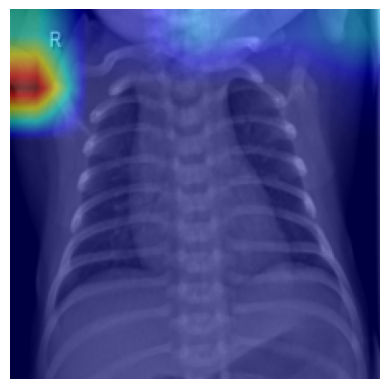

In [1]:
import datamodule
import models
import gradcam
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt

reload(datamodule)
reload(models)
reload(gradcam)


def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):

    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

dm = datamodule.Datamodule()
dm.setup()
dl = dm.train_dataloader()
batch = next(iter(dl))
X, y = batch
# plt.imshow(X.permute(1, 2, 0))
# y = "COVID19" if y else "NORMAL"
# plt.title(f"{y}")
# plt.show()

model = models.BaseCNN.load_from_checkpoint("/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/rn_0.03.ckpt")
model.eval()
pred = model.predict(X)
exit()
gcam = gradcam.GradCAM(model.model.cpu())
cam = gcam(X[[0]])
print(pred.view(-1).cpu() == y)
overlay = overlay_gradcam_on_image(X[[0]], cam)
plt.imshow(overlay)
plt.axis('off')
plt.title(f"pred={pred[0].item()} true={y.item()}")
plt.show()

<Axes: >

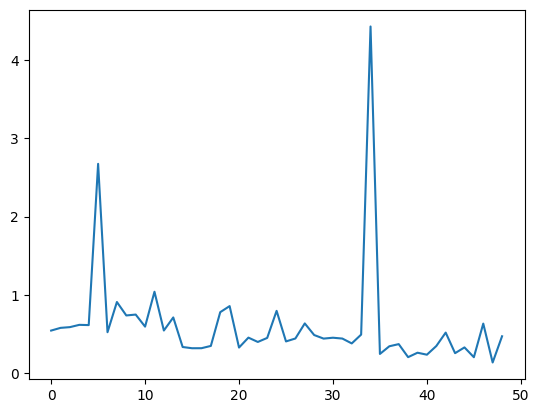

In [1]:
import pandas as pd

ans = pd.read_csv("/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/lightning_logs/version_4/metrics.csv")

ans["train/loss"].plot()

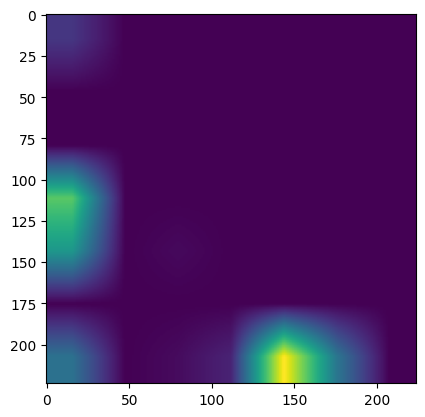

In [6]:
plt.imshow(out)